# Blasius equation
Solution using a simple shooting method (bisection) and Runge-Kutta RK4 integration, and some simple comparisons to the quadratic velocity profile.

Adapted 2021-2025 by Philipp Schlatter (LSTM, FAU)

Binder: https://mybinder.org/v2/gh/pschlatt1/notebooks/main?filepath=blasius.ipynb

Colab: https://colab.research.google.com/github/pschlatt1/notebooks/blob/main/blasius.ipynb

## Preliminaries

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  # for Google Colab and interative figures
  !pip install -q ipympl
  from google.colab import output
  output.enable_custom_widget_manager()

In [2]:
#%matplotlib notebook
%matplotlib widget
#%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 12,
          'legend.loc':'best',
          'figure.figsize': (8,5),
          'lines.markerfacecolor':'none',
          'axes.labelsize': 12,
          'axes.titlesize': 12,
          'xtick.labelsize':12,
          'ytick.labelsize':12,
          'grid.alpha':0.6,
          'text.usetex':False}
pylab.rcParams.update(params)

## Blasius solution

The equation to solve is
$$f'''+\frac{1}{2} f f'' = 0 \ ,$$
subject to boundary conditions
$$f(0)=0, f'(0)=0, f'(\infty) = 1 \ .$$

We thus define first our equation:

In [3]:
def ff(u):
    f0 =   u[1]
    f1 =   u[2]
    f2 = - 0.5*u[0] * u[2]
    return np.array([f0,f1,f2])

and then the standard Runge-Kutta ODE integrator RK4, using the (unknown) initial value $a$ for $f''(0)$

In [4]:
def RK4(a,h,L):
    imax = int(L/h)
    X = np.arange(imax+1)*h
    U = np.zeros((imax+1,3)); U[0,:] = [0,0,a]
    for i in range(imax):
        K1 = ff(U[i,:]       )
        K2 = ff(U[i,:]+K1*h/2)
        K3 = ff(U[i,:]+K2*h/2)
        K4 = ff(U[i,:]+K3*h  )
        U[i+1,:] = U[i,:] + h*(K1+2*K2+2*K3+K4)/6
    return X,U

The shooting function returns the value $1-f'(\infty)$ (approximated as $1-f'(L)$):

In [5]:
def shoot(a,h,L):
    X,U = RK4(a,h,L)
    return (1.0-U[-1,1])

The function `blasius` is performing a bisection method, in an effort to bring the error of $f'(L)=1$ below the specified tolerance

In [6]:
def blasius(h,L,tol,nmax):
    a = 0; fa = shoot(a,h,L)
    b = 1; fb = shoot(b,h,L)
    if (fa*fb > 0):
        raise RuntimeError('Bad initial interval.')
    n = 0; delta = (b-a)/2
    while (abs(delta) >= tol and n <= nmax):
        delta = (b-a)/2; n = n + 1;
        x = a + delta; fx = shoot(x,h,L)
        print(" x = %14.7e (Estimated error %13.7e at iteration %d)" % (x,abs(delta),n))
        if (fx*fa > 0):
            a = x;  fa = fx
        else :
            b = x;  fb = fx
    if (n > nmax):
        raise RuntimeError('Too many iterations.')
    return x

Finally, the main script calls the `blasius` function and computes the solution in $Y$ and $F$.

In [7]:
# parameters
nmax = 100
h   = 0.01
L   = 30
tol = 1e-8

In [8]:
# compute the value of f''(0)
a = blasius(h,L,tol,nmax)
# recompute the Blasius solution with the optimised value for f''(0)
eta,f = RK4(a,h,L)

print("Final value for f''(0) = %.10f " % f[0,2])

 x =  5.0000000e-01 (Estimated error 5.0000000e-01 at iteration 1)
 x =  2.5000000e-01 (Estimated error 2.5000000e-01 at iteration 2)
 x =  3.7500000e-01 (Estimated error 1.2500000e-01 at iteration 3)
 x =  3.1250000e-01 (Estimated error 6.2500000e-02 at iteration 4)
 x =  3.4375000e-01 (Estimated error 3.1250000e-02 at iteration 5)
 x =  3.2812500e-01 (Estimated error 1.5625000e-02 at iteration 6)
 x =  3.3593750e-01 (Estimated error 7.8125000e-03 at iteration 7)
 x =  3.3203125e-01 (Estimated error 3.9062500e-03 at iteration 8)
 x =  3.3398438e-01 (Estimated error 1.9531250e-03 at iteration 9)
 x =  3.3300781e-01 (Estimated error 9.7656250e-04 at iteration 10)
 x =  3.3251953e-01 (Estimated error 4.8828125e-04 at iteration 11)
 x =  3.3227539e-01 (Estimated error 2.4414062e-04 at iteration 12)
 x =  3.3215332e-01 (Estimated error 1.2207031e-04 at iteration 13)
 x =  3.3209229e-01 (Estimated error 6.1035156e-05 at iteration 14)
 x =  3.3206177e-01 (Estimated error 3.0517578e-05 at ite

Finally, let us plot the results for the similarity function and its derivatives:

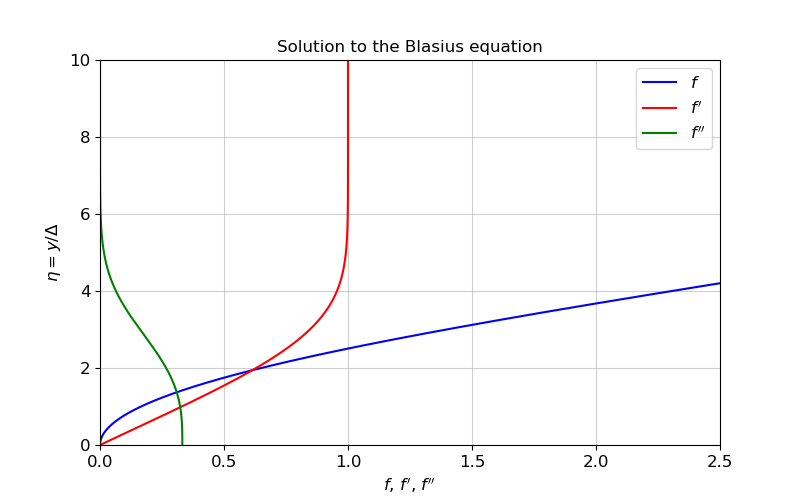

In [9]:
fig=plt.figure()
#fig.canvas.header_visible = False
plt.title('Solution to the Blasius equation')
plt.plot(f[:,0],eta,'-b',label="$f$")
plt.plot(f[:,1],eta,'-r',label="$f'$")
plt.plot(f[:,2],eta,'-g',label="$f''$")
plt.xlim([0, 2.5])
plt.ylim([0,10])
plt.grid()
plt.xlabel(r"$f$, $f'$, $f''$")
plt.ylabel(r'$\eta = y/\Delta$')
plt.legend(loc='best')
plt.show()

Let us now compute some integral quantities: (Blasius length scale $\Delta$, boundary-layer thickness $\delta_{99}$, displacement thickness $\delta^*$, momentum-loss thickness $\theta$, shape factor $H_{12}$)

In [10]:
d99 = np.interp(0.99,f[:,1],eta)
d1 = eta[-1]-f[-1,0]
d2 = 2*f[0,2]   # only valid for Blasius, otherwise use d2 = np.trapz(f[:,1]*(1-f[:,1]),eta)
H12 = d1/d2
print('d99   / Delta = %14.10g' % d99)
print('dstar / Delta = %14.10g' % d1)
print('theta / Delta = %14.10g' % d2)
print('H12           = %14.10g' % H12)
print('dstar/d99     = %14.10g' % float(d1/d99))
print('theta/d99     = %14.10g' % float(d2/d99))

d99   / Delta =    4.909989791
dstar / Delta =    1.720787759
theta / Delta =    0.664114669
H12           =    2.591100362
dstar/d99     =   0.3504666674
theta/d99     =   0.1352578513


## Checks of the integral values using integrals

Useful to remember is that the displacement thickness is about a third of $\delta_{99}$, and the momentum thickness about a tenth of $\delta_{99}$.



The Blasius boundary layer thickness $$\Delta = \sqrt{\frac{\nu x}{U_\infty}} = \frac{x}{\sqrt{Re_x}} $$ is used for non-dimensionalisation of length, and $U_\infty$ for velocity. The streamwise velocity is $$u(y/\Delta)/U_\infty = f'(\eta) \ .$$ Thus, the local skin-friction coefficient $$c_f = \frac{\tau_w}{\frac12 \rho U_\infty^2}= \frac{2 f''(0)}{\sqrt{Re_x}}=\frac{0.664}{\sqrt{Re_x}}$$ is computed using the wall-shear stress $$\tau_w = \mu \frac{\mathrm \partial u}{\partial y}|_{y=0} =\mu \frac{U_\infty f''(0)}{\Delta} =f''(0) \frac{\rho U_\infty^2}{\sqrt{Re_x}}\ .$$

In [11]:
print("2f''(0)     = %14.10g" % float(2*f[0,2]))

2f''(0)     =    0.664114669


The von Kármán integral equation states for a Blasius boundary layer ($U_\infty = \text{constant}$) $$c_f = 2 \frac{\mathrm d \theta}{\mathrm d x}\ ,$$
and with the definition of $\theta$ we get
$$ c_f = 2 \frac{\mathrm d \theta}{\mathrm d x} = \frac{\theta}{x}\ ,$$ since $\theta$ grows as a square root of $x$.

These integral quantities can also be verified by integration using the trapezoidal rule:

$$\delta^* = \int_0^\infty (1-u/U_\infty) \mathrm dy = \Delta \int_0^\infty (1-f') \mathrm d\eta$$

$$\theta = \int_0^\infty (u/U_\infty)(1-u/U_\infty) \mathrm dy = \Delta \int_0^\infty f'(1-f') \mathrm d\eta$$

In [12]:
np.trapz(1-f[:,1],eta)           # displacement thickness

1.72079052609218

In [13]:
np.trapz(f[:,1]*(1-f[:,1]),eta)  # momentum thickness

0.6641120002512727

## Comparison with the parabolic profile (e.g. from channel flow)

In [14]:
par = np.hstack( (-eta[eta<=1]**2+2*eta[eta<=1], -eta[eta>1]*0+1  ))

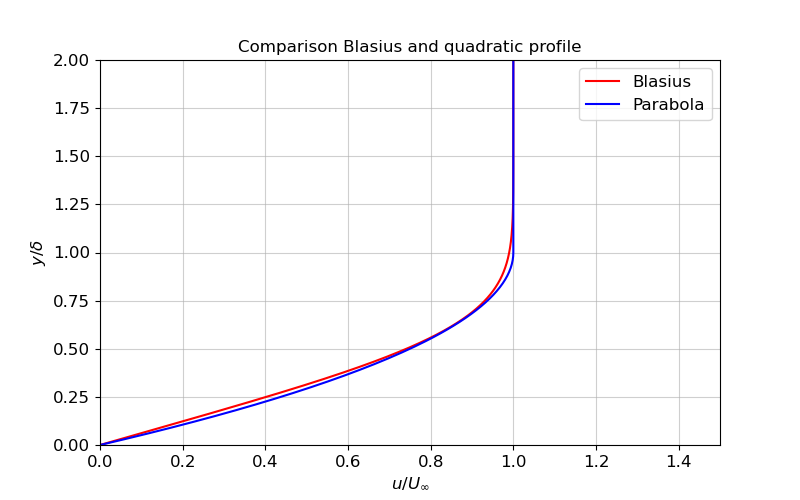

In [15]:
fig=plt.figure()
#fig.canvas.header_visible = False
plt.title('Comparison Blasius and quadratic profile')
plt.plot(f[:,1],eta/d99,'-r',label="Blasius")
plt.plot(par,eta,'-b',label="Parabola")

plt.xlim([0, 1.5])
plt.ylim([0,2])
plt.grid()
plt.xlabel(r"$u/U_\infty$")
plt.ylabel(r'$y/\delta$')
plt.legend(loc='best')
plt.show()